In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
#iteration is for the tensorboard file.
iteration = 2
layers = 3
dimensions = [(2,16), (16,16), (16,1)]
samples = 300
degrees = 180
noise  = 0.60
batch_size = 20
NUM_BATCHES = 1000
lr = 1e-4
np.random.seed(1234)
tf.set_random_seed(1234)
h = 0.1

In [3]:
def variable_summaries(var, name):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [4]:
def create_spirals(samples,circles,noise):
    n = np.sqrt(np.random.rand(samples,1)) * circles * (2*np.pi)/360
    x1 = np.cos(n)*n + np.random.rand(samples,1) * noise
    x2 = np.sin(n)*n + np.random.rand(samples,1) * noise
#     x1 = n + np.random.rand(samples,1) * noise
#     x2 = n + np.random.rand(samples,1) * noise
    Spiral1 = np.hstack((x1,x2))
    Spiral2 = np.hstack((-x1,-x2))
    Spirals = np.vstack((Spiral1,Spiral2))
    Y = np.hstack((np.zeros(samples),np.ones(samples)))
    plt.title("Spirals")
    plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
    plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)
    return Spirals,Y,Spiral1,Spiral2

In [5]:
def init_variables(layers, dimensions):
    weights_dictionary = {}
    biases_dictionary = {}
    for i in range(layers):
        nameW = "w{}".format(i)
        nameB = "b{}".format(i)
        weights_dictionary[nameW] = tf.get_variable(nameW,dimensions[i], tf.float32, tf.truncated_normal_initializer()) 
        biases_dictionary[nameW] = tf.get_variable(nameB, [1,dimensions[i][1]], tf.float32, tf.zeros_initializer())
        variable_summaries(weights_dictionary[nameW], nameW)
        variable_summaries(biases_dictionary[nameW], nameB)
    return weights_dictionary, biases_dictionary


In [6]:
def f(x,weights_dictionary,biases_dictionary):
    for weight in weights_dictionary:
        if weight == "w0":
            y_hat = tf.matmul(x,weights_dictionary[weight]) + biases_dictionary[weight]
        else: 
            y_hat = tf.matmul(tf.nn.elu(y_hat),weights_dictionary[weight]) + biases_dictionary[weight]
    return y_hat



In [7]:
def initialize_network(weights_dictionary,biases_dictionary):
    a = tf.placeholder(tf.float32, [batch_size,2])
    b = tf.placeholder(tf.float32, [batch_size,1])
    y_hat = f(a,weights_dictionary,biases_dictionary)
    #eventually add regularization term
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=b, logits=y_hat))
    optim = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    return sess,loss,optim,a,b

In [8]:
def train(sess, loss,optim,a,b, iteration):
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter("./train{}".format(iteration), sess.graph)
    for i in tqdm(range(0,NUM_BATCHES)):
        #need to sample points, we do samples*2, just because the way the points were generated
        choices = np.random.choice(samples*2,batch_size)
        x_np = Spirals[choices]
        y_np = np.array(Y[choices]).reshape(batch_size,1)
        loss_np, _ = sess.run([loss,optim],feed_dict={a:x_np, b:y_np})
        summary = sess.run(merged, feed_dict={a:x_np, b:y_np})
        train_writer.add_summary(summary,i)
        if i<10 or i>(NUM_BATCHES-10):
            print(loss_np)

In [9]:
def draw_contour(h):
    xx,yy = np.meshgrid(np.arange(-7,7,h), np.arange(-7,7,h))
    inputx = np.stack((xx,yy), axis=2)
    y_hats = np.array([])
    c = tf.placeholder(tf.float32, [inputx.shape[0],2])
    y_hat = f(c,weights_dictionary,biases_dictionary)

    for i in tqdm(range(inputx.shape[0])):
        if y_hats.size>0: 
            y_hats = np.hstack((y_hats,sess.run(y_hat,{c: inputx[i]})))
        else: 
            y_hats = sess.run(y_hat,{c:inputx[i]})
    y_hats[y_hats>0] = 1
    y_hats[y_hats<=0] = 0
    plt.contourf(xx,yy,y_hats,alpha=0.5)
    plt.plot(Spiral1[0:-1,0], Spiral1[0:-1,1], ".", label="Spiral 1", alpha=0.5)
    plt.plot(Spiral2[0:-1,0], Spiral2[0:-1,1], ".", label="Spiral 2", alpha=0.5)

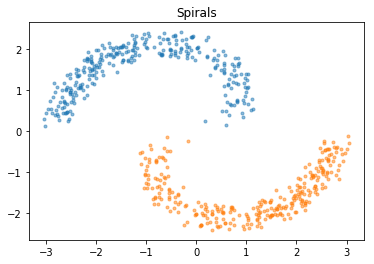

In [10]:
Spirals,Y,Spiral1,Spiral2 = create_spirals(samples,degrees,noise)

In [11]:
weights_dictionary,biases_dictionary = init_variables(layers,dimensions)


In [12]:
sess,loss,optim,a,b = initialize_network(weights_dictionary,biases_dictionary)

In [15]:
train(sess,loss,optim,a,b,iteration)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

7.606842


  0%|                                                                                 | 1/1000 [00:00<01:46,  9.37it/s]

7.8529005
6.8357286
9.835472
10.77875
10.554255
8.509481
10.429537
7.9581666
12.165841


 97%|███████████████████████████████████████████████████████████████████████████▉  | 974/1000 [00:04<00:00, 210.93it/s]

0.54149544
0.49292642
0.5366665
0.22028549
0.52939814
0.30587354
0.46020737


100%|█████████████████████████████████████████████████████████████████████████████▊| 998/1000 [00:04<00:00, 209.92it/s]

0.14444749
0.18618721


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 209.68it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 2034.52it/s]


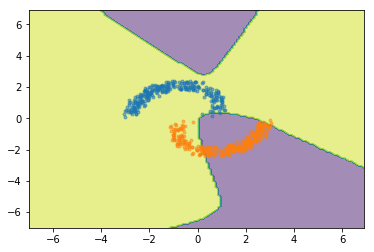

In [16]:
draw_contour(h)